In [21]:
import melanoma as mel

%matplotlib inline
%load_ext autoreload
%autoreload -p 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

rootpath = '/hpcstor6/scratch01/s/sanghyuk.kim001'
img_size = (112, 150) # height, width
utilInstance = mel.Util(rootpath, img_size)
dataType = mel.DatasetType.ISIC2017


DEBUG = 0
# Save datasets as pickle files
if (DEBUG == 1):
    utilInstance.saveDatasetsToFile(dataType)

dbpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB'

trainimages_HAM10000, testimages_HAM10000, validationimages_HAM10000, \
			trainlabels_binary_HAM10000, testlabels_binary_HAM10000, validationlabels_binary_HAM10000, num_classes_binary_HAM10000\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2016, testimages_ISIC2016, validationimages_ISIC2016, \
			trainlabels_binary_ISIC2016, testlabels_binary_ISIC2016, validationlabels_binary_ISIC2016, num_classes_binary_ISIC2016\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2017, testimages_ISIC2017, validationimages_ISIC2017, \
			trainlabels_binary_ISIC2017, testlabels_binary_ISIC2017, validationlabels_binary_ISIC2017, num_classes_binary_ISIC2017\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl')



img_height, img_width = utilInstance.getImgSize()
CFG = dict(
			batch_size            =  25,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
			epochs                =  100,   # 5; 10; 20;
			last_trainable_layers =   0,
			verbose               =   1,   # 0; 1
			fontsize              =  14,
			num_classes           =  2, # binary

			# Images sizes
			img_height = img_height,   # Original: (450h, 600w)
            img_width = img_width,

			# Images augs
			ROTATION_RANGE        =  90.0,
			ZOOM_RANGE            =   0.1,
			HSHIFT_RANGE          =   0.1, # randomly shift images horizontally
			WSHIFT_RANGE          =   0.1, # randomly shift images vertically
			HFLIP                 = False, # randomly flip images
			VFLIP                 = False, # randomly flip images

			# Postprocessing
			stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
			run_functions_eagerly = False,
            
            # save
            snapshot_path = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot'
		)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Building HAM10000 binary training on ResNet50 model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None
Fitting HAM10000 binary training on ResNet

/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
321/321 [==============================] - 29s 91ms/step - loss: 2.7079 - accuracy: 0.8519 - val_loss: 2.1319 - val_accuracy: 0.9445
Epoch 3/100
321/321 [==============================] - 29s 90ms/step - loss: 1.9593 - accuracy: 0.8659 - val_loss: 1.5966 - val_accuracy: 0.9479
Epoch 4/100
321/321 [==============================] - 29s 90ms/step - loss: 1.5175 - accuracy: 0.8706 - val_loss: 1.2234 - val_accuracy: 0.9456
Epoch 5/100
321/321 [==============================] - 29s 90ms/step - loss: 1.2222 - accuracy: 0.8732 - val_loss: 0.9860 - val_accuracy: 0.9445
Epoch 6/100
321/321 [==============================] - 29s 90ms/step - loss: 1.0063 - accuracy: 0.8772 - val_loss: 0.7834 - val_accuracy: 0.9456
Epoch 7/100
321/321 [==============================] - 29s 90ms/step - loss: 0.8613 - accuracy: 0.8747 - val_loss: 0.6727 - val_accuracy: 0.9479
Epoch 8/100
321/321 [==============================] - 29s 90ms/step - loss: 0.7429 - accuracy: 0.8788 - val_loss: 0.5612 - val_ac

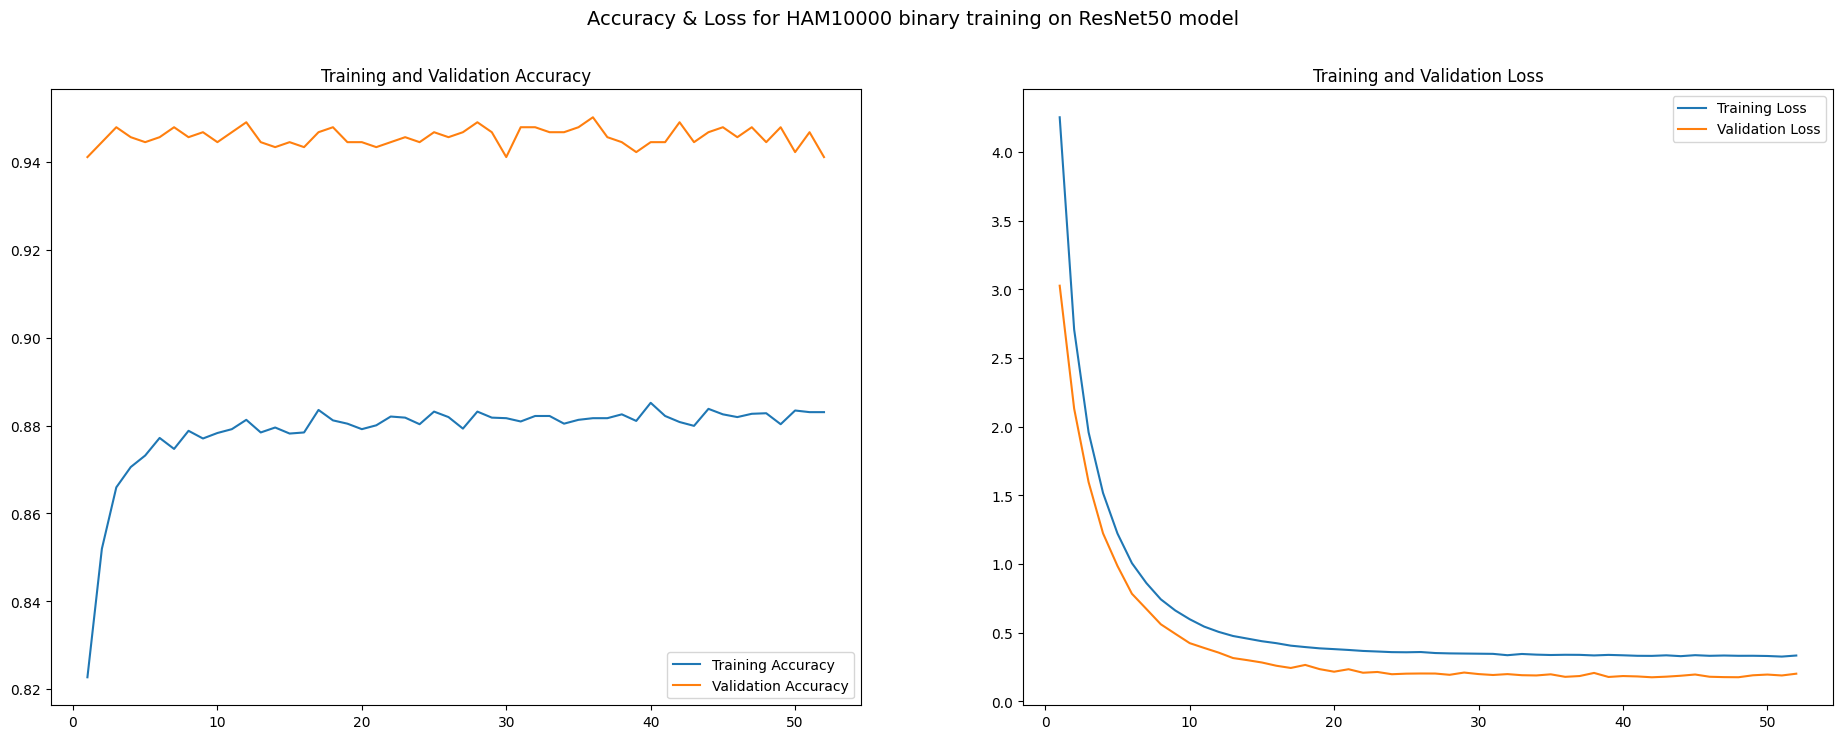

In [9]:
# Solely training HAM10000

base_model_binary = mel.CNN(trainimages_HAM10000, trainlabels_binary_HAM10000, \
    validationimages_HAM10000, validationlabels_binary_HAM10000, \
        testimages_HAM10000, testlabels_binary_HAM10000, CFG)
ResNet50_name = 'HAM10000 binary training on ResNet50'
data_gen_HAM10000, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000
history_HAM10000_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000,
    trainlabels = trainlabels_binary_HAM10000,
    validationimages = validationimages_HAM10000,
    validationlabels = validationlabels_binary_HAM10000,
    data_gen = data_gen_HAM10000
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_bin
)

Input 0: HAM10000 train images
Input 1: ISIC2016 train images
Combined images: HAM10000 train images AND ISIC2016 train images AND 
Input 0: HAM10000 test images
Input 1: ISIC2016 test images
Combined images: HAM10000 test images AND ISIC2016 test images AND 
Input 0: HAM10000 validation images
Input 1: ISIC2016 validation images
Combined images: HAM10000 validation images AND ISIC2016 validation images AND 
Input: 0: HAM10000 train labels
Input: 1: ISIC2016 train labels
Combined labels: HAM10000 train labels AND ISIC2016 train labels AND 
Input: 0: HAM10000 test labels
Input: 1: ISIC2016 test labels
Combined labels: HAM10000 test labels AND ISIC2016 test labels AND 
Input: 0: HAM10000 validation labels
Input: 1: ISIC2016 validation labels
Combined labels: HAM10000 validation labels AND ISIC2016 validation labels AND 
Building HAM10000 + ISIC2016 binary training on ResNet50 model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)    

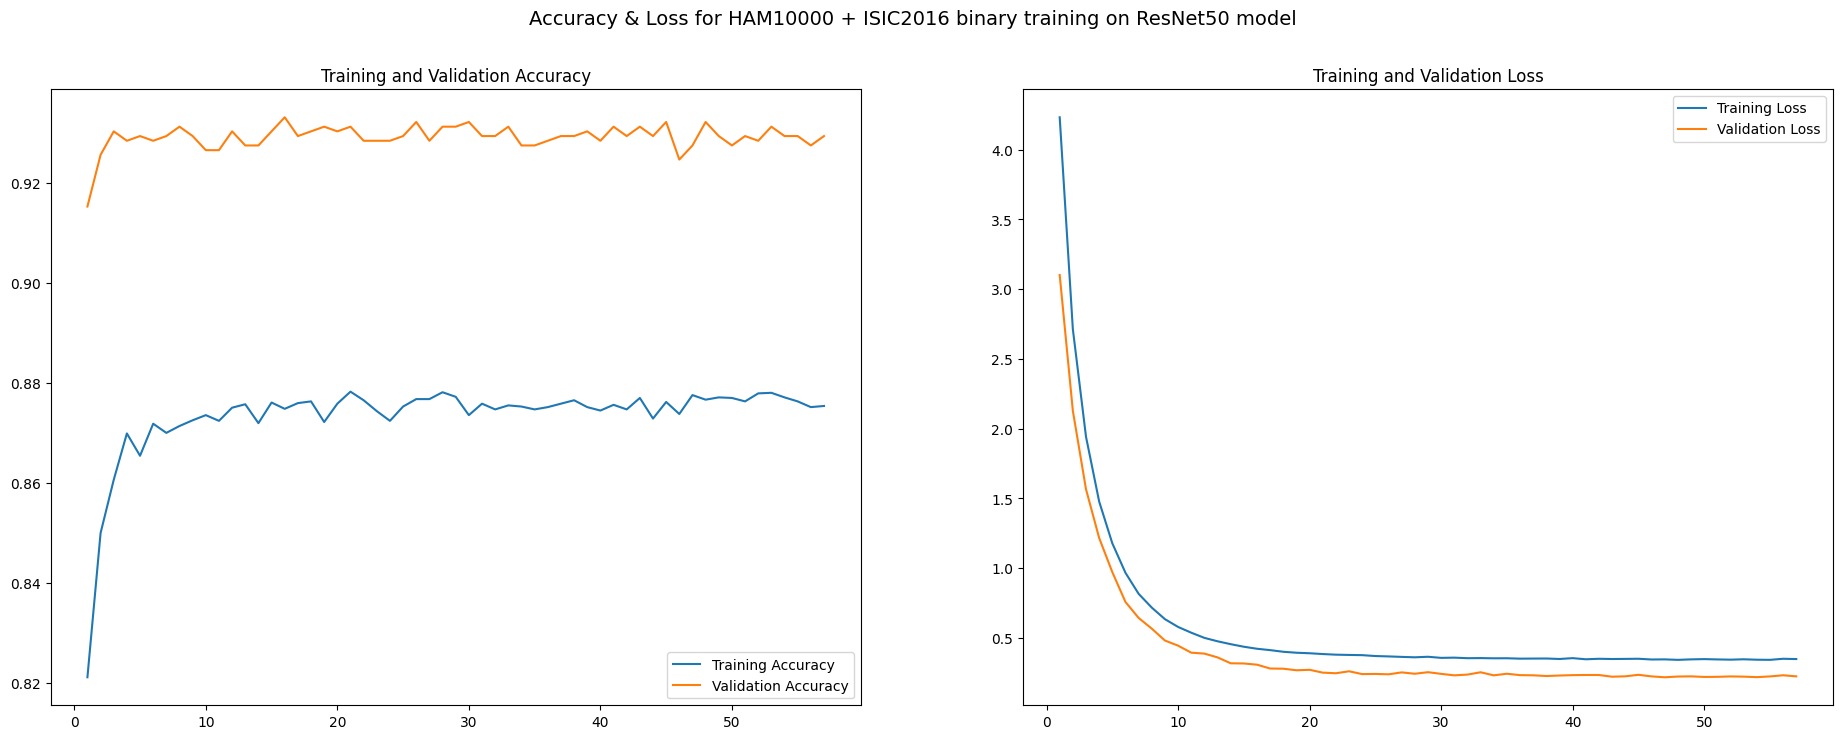

In [10]:
# HAM10000 + ISIC2016 binary training

# Now, let's combine HAM10000 and ISIC2016 DBs
trainimages_combination = {"HAM10000 train images":trainimages_HAM10000, "ISIC2016 train images":trainimages_ISIC2016}
testimages_combination = {"HAM10000 test images":testimages_HAM10000, "ISIC2016 test images":testimages_ISIC2016}
validationimages_combination = {"HAM10000 validation images":validationimages_HAM10000, "ISIC2016 validation images":validationimages_ISIC2016}
trainlabels_combination = {"HAM10000 train labels":trainlabels_binary_HAM10000, "ISIC2016 train labels":trainlabels_binary_ISIC2016}
testlabels_combination = {"HAM10000 test labels":testlabels_binary_HAM10000, "ISIC2016 test labels":testlabels_binary_ISIC2016}
validationlabels_combination = {"HAM10000 validation labels":validationlabels_binary_HAM10000, "ISIC2016 validation labels":validationlabels_binary_ISIC2016}

trainimages_HAM10000_ISIC2016 = utilInstance.combine_images(**trainimages_combination)
testimages_HAM10000_ISIC2016 = utilInstance.combine_images(**testimages_combination)
validationimages_HAM10000_ISIC2016 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**validationlabels_combination)


base_model_binary = mel.CNN(trainimages_HAM10000_ISIC2016, trainlabels_binary_HAM10000_ISIC2016, \
    validationimages_HAM10000_ISIC2016, validationlabels_binary_HAM10000_ISIC2016, \
        testimages_HAM10000_ISIC2016, testlabels_binary_HAM10000_ISIC2016, CFG)
ResNet50_name = 'HAM10000 + ISIC2016 binary training on ResNet50'
data_gen_HAM10000_ISIC2016, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000 + ISIC2016
history_HAM10000_ISIC2016_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000_ISIC2016,
    trainlabels = trainlabels_binary_HAM10000_ISIC2016,
    validationimages = validationimages_HAM10000_ISIC2016,
    validationlabels = validationlabels_binary_HAM10000_ISIC2016,
    data_gen = data_gen_HAM10000_ISIC2016
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_ISIC2016_bin
)

Input 0: HAM10000 train images
Input 1: ISIC2016 train images


Input 2: ISIC2017 train images
Combined images: HAM10000 train images AND ISIC2016 train images AND ISIC2017 train images AND 
Input 0: HAM10000 test images
Input 1: ISIC2016 test images
Input 2: ISIC2017 test images
Combined images: HAM10000 test images AND ISIC2016 test images AND ISIC2017 test images AND 
Input 0: HAM10000 validation images
Input 1: ISIC2016 validation images
Input 2: ISIC2017 validation images
Combined images: HAM10000 validation images AND ISIC2016 validation images AND ISIC2017 validation images AND 
Input: 0: HAM10000 train labels
Input: 1: ISIC2016 train labels
Input: 2: ISIC2017 train labels
Combined labels: HAM10000 train labels AND ISIC2016 train labels AND ISIC2017 train labels AND 
Input: 0: HAM10000 test labels
Input: 1: ISIC2016 test labels
Input: 2: ISIC2017 test labels
Combined labels: HAM10000 test labels AND ISIC2016 test labels AND ISIC2017 test labels AND 
Input: 0: HAM10000 validation labels
Input: 1: ISIC2016 validation labels
Input: 2: ISIC2017 

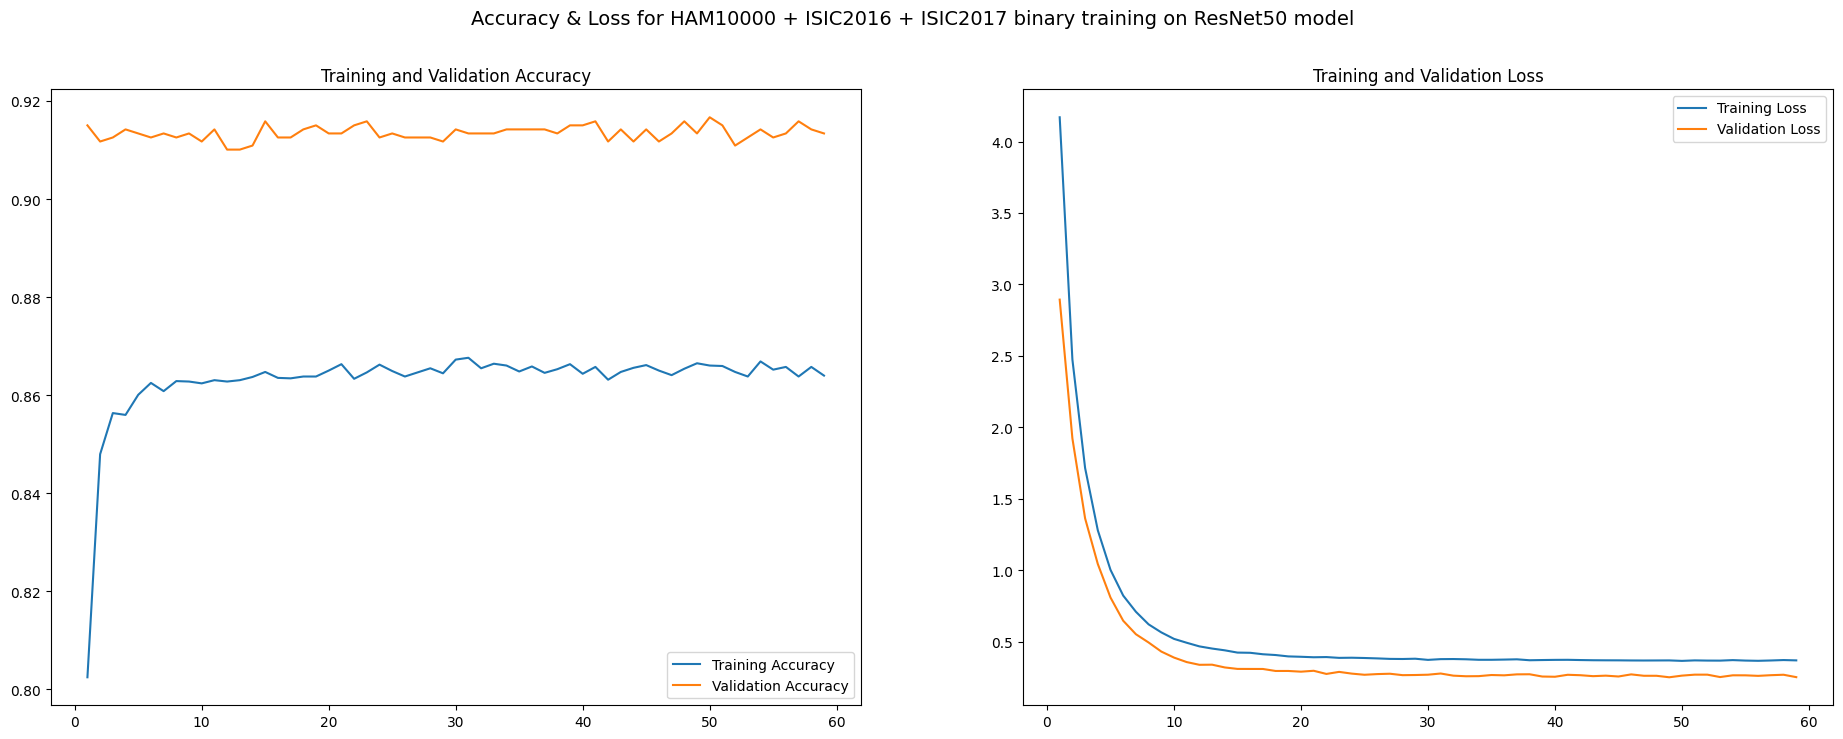

In [11]:
# HAM10000 + ISIC2016 + ISIC2017 binary training

# Now, let's combine HAM10000, ISIC2016 and ISIC2017
trainimages_combination = {"HAM10000 train images":trainimages_HAM10000, "ISIC2016 train images":trainimages_ISIC2016, "ISIC2017 train images":trainimages_ISIC2017}
testimages_combination = {"HAM10000 test images":testimages_HAM10000, "ISIC2016 test images":testimages_ISIC2016, "ISIC2017 test images":testimages_ISIC2017}
validationimages_combination = {"HAM10000 validation images":validationimages_HAM10000, "ISIC2016 validation images":validationimages_ISIC2016, "ISIC2017 validation images":validationimages_ISIC2017}
trainlabels_combination = {"HAM10000 train labels":trainlabels_binary_HAM10000, "ISIC2016 train labels":trainlabels_binary_ISIC2016, "ISIC2017 train labels":trainlabels_binary_ISIC2017}
testlabels_combination = {"HAM10000 test labels":testlabels_binary_HAM10000, "ISIC2016 test labels":testlabels_binary_ISIC2016, "ISIC2017 test labels":testlabels_binary_ISIC2017}
validationlabels_combination = {"HAM10000 validation labels":validationlabels_binary_HAM10000, "ISIC2016 validation labels":validationlabels_binary_ISIC2016, "ISIC2017 validation labels":validationlabels_binary_ISIC2017}

trainimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**trainimages_combination)
testimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**testimages_combination)
validationimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**validationlabels_combination)


base_model_binary = mel.CNN(trainimages_HAM10000_ISIC2016_ISIC2017, trainlabels_binary_HAM10000_ISIC2016_ISIC2017, \
    validationimages_HAM10000_ISIC2016_ISIC2017, validationlabels_binary_HAM10000_ISIC2016_ISIC2017, \
        testimages_HAM10000_ISIC2016_ISIC2017, testlabels_binary_HAM10000_ISIC2016_ISIC2017, CFG)
ResNet50_name = 'HAM10000 + ISIC2016 + ISIC2017 binary training on ResNet50'
data_gen_HAM10000_ISIC2016_ISIC2017, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000 + ISIC2016 + ISIC2017
history_HAM10000_ISIC2016_ISIC2017_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000_ISIC2016_ISIC2017,
    trainlabels = trainlabels_binary_HAM10000_ISIC2016_ISIC2017,
    validationimages = validationimages_HAM10000_ISIC2016_ISIC2017,
    validationlabels = validationlabels_binary_HAM10000_ISIC2016_ISIC2017,
    data_gen = data_gen_HAM10000_ISIC2016_ISIC2017
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_ISIC2016_ISIC2017_bin
)

Building ISIC2016 binary training on ResNet50 model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None
Fitting ISIC2016 binary training on ResNet

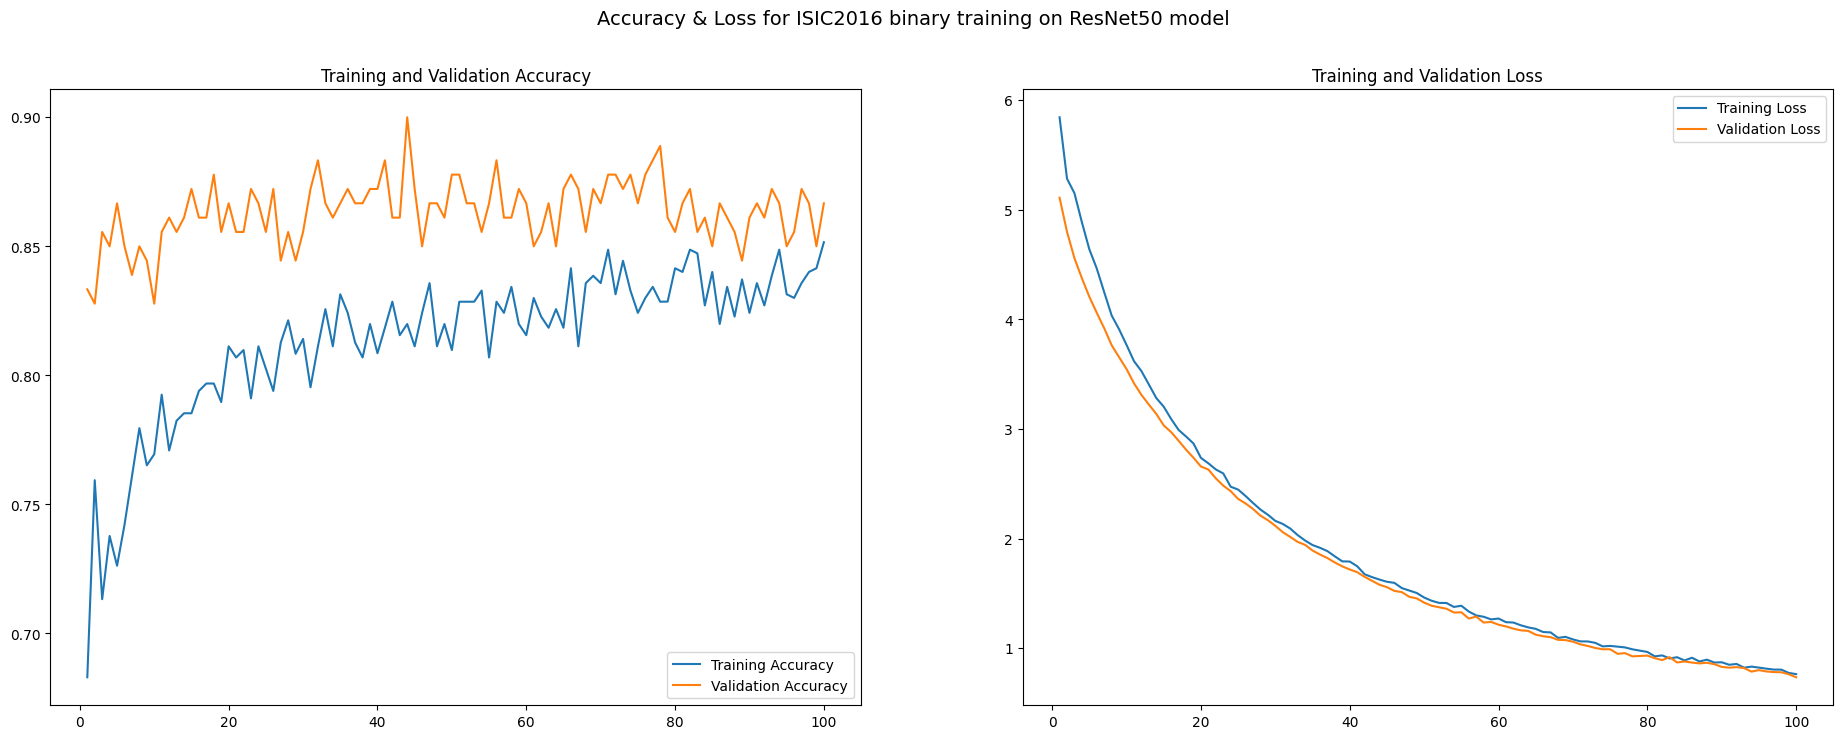

In [12]:
# Solely training ISIC2016

base_model_binary = mel.CNN(trainimages_ISIC2016, trainlabels_binary_ISIC2016, \
    validationimages_ISIC2016, validationlabels_binary_ISIC2016, \
        testimages_ISIC2016, testlabels_binary_ISIC2016, CFG)
ResNet50_name = 'ISIC2016 binary training on ResNet50'
data_gen_ISIC2016, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train ISIC2016
history_ISIC2016_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    data_gen = data_gen_ISIC2016
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_ISIC2016_bin
)

Building ISIC2017 binary training on ResNet50 model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None
Fitting ISIC2017 binary training on ResNet

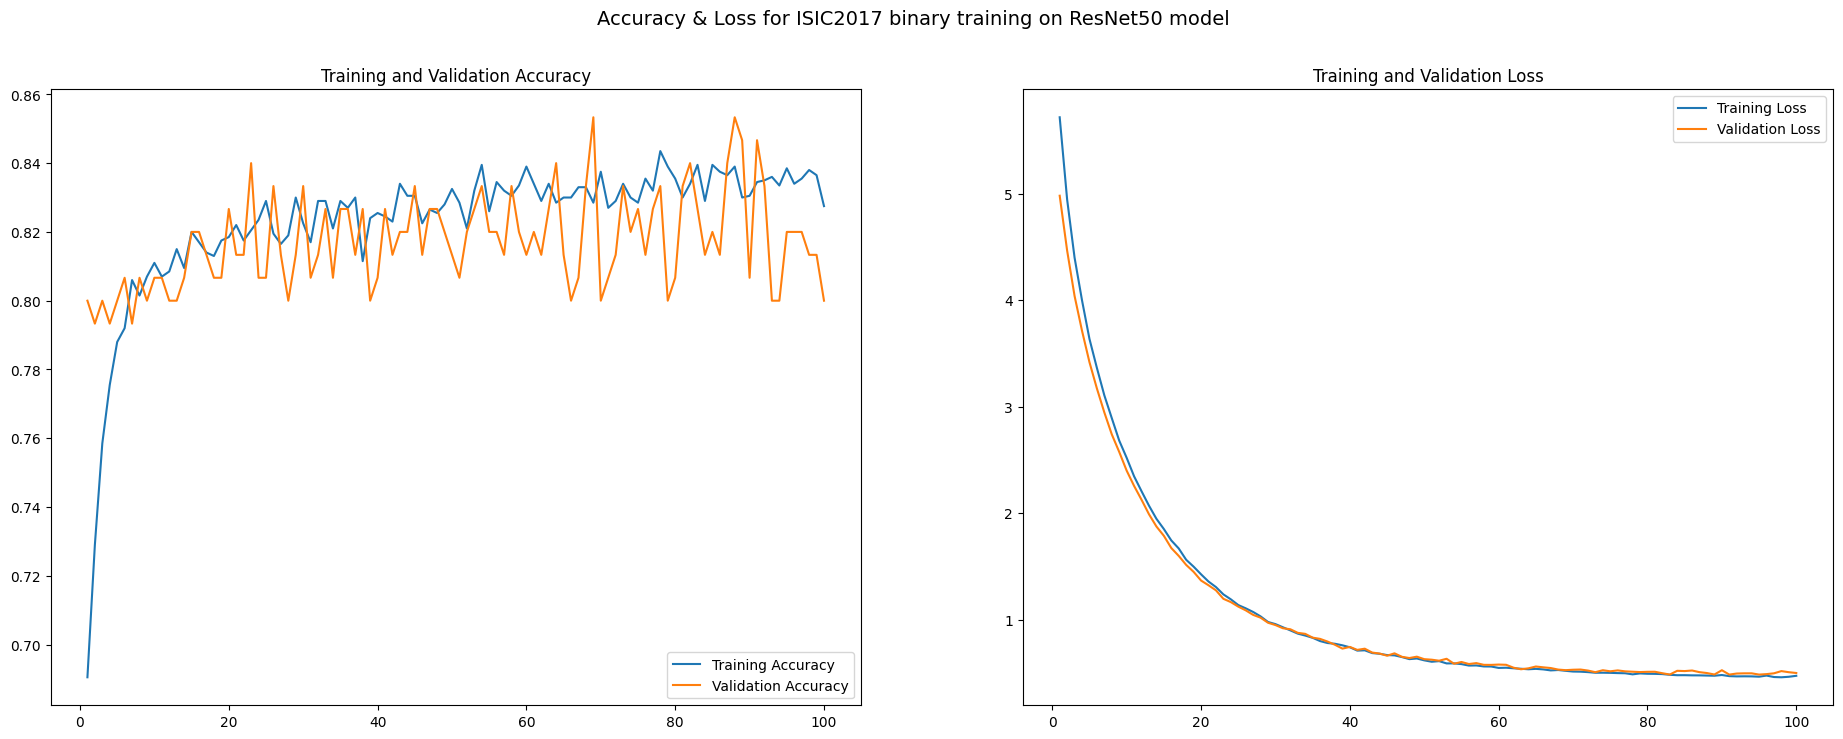

In [13]:
# Solely training ISIC2017

base_model_binary = mel.CNN(trainimages_ISIC2017, trainlabels_binary_ISIC2017, \
    validationimages_ISIC2017, validationlabels_binary_ISIC2017, \
        testimages_ISIC2017, testlabels_binary_ISIC2017, CFG)
ResNet50_name = 'ISIC2017 binary training on ResNet50'
data_gen_ISIC2017, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train ISIC2017
history_ISIC2017_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    data_gen = data_gen_ISIC2017
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_ISIC2017_bin
)

Input 0: ISIC2016 train images
Input 1: ISIC2017 train images
Combined images: ISIC2016 train images AND ISIC2017 train images AND 
Input 0: ISIC2016 test images
Input 1: ISIC2017 test images
Combined images: ISIC2016 test images AND ISIC2017 test images AND 
Input 0: ISIC2016 validation images
Input 1: ISIC2017 validation images
Combined images: ISIC2016 validation images AND ISIC2017 validation images AND 
Input: 0: ISIC2016 train labels
Input: 1: ISIC2017 train labels
Combined labels: ISIC2016 train labels AND ISIC2017 train labels AND 
Input: 0: ISIC2016 test labels
Input: 1: ISIC2017 test labels
Combined labels: ISIC2016 test labels AND ISIC2017 test labels AND 
Input: 0: ISIC2016 validation labels
Input: 1: ISIC2017 validation labels
Combined labels: ISIC2016 validation labels AND ISIC2017 validation labels AND 
Building ISIC2016 + ISIC2017 binary training on ResNet50 model...
Model: "sequential_8"
_________________________________________________________________
Layer (type)    

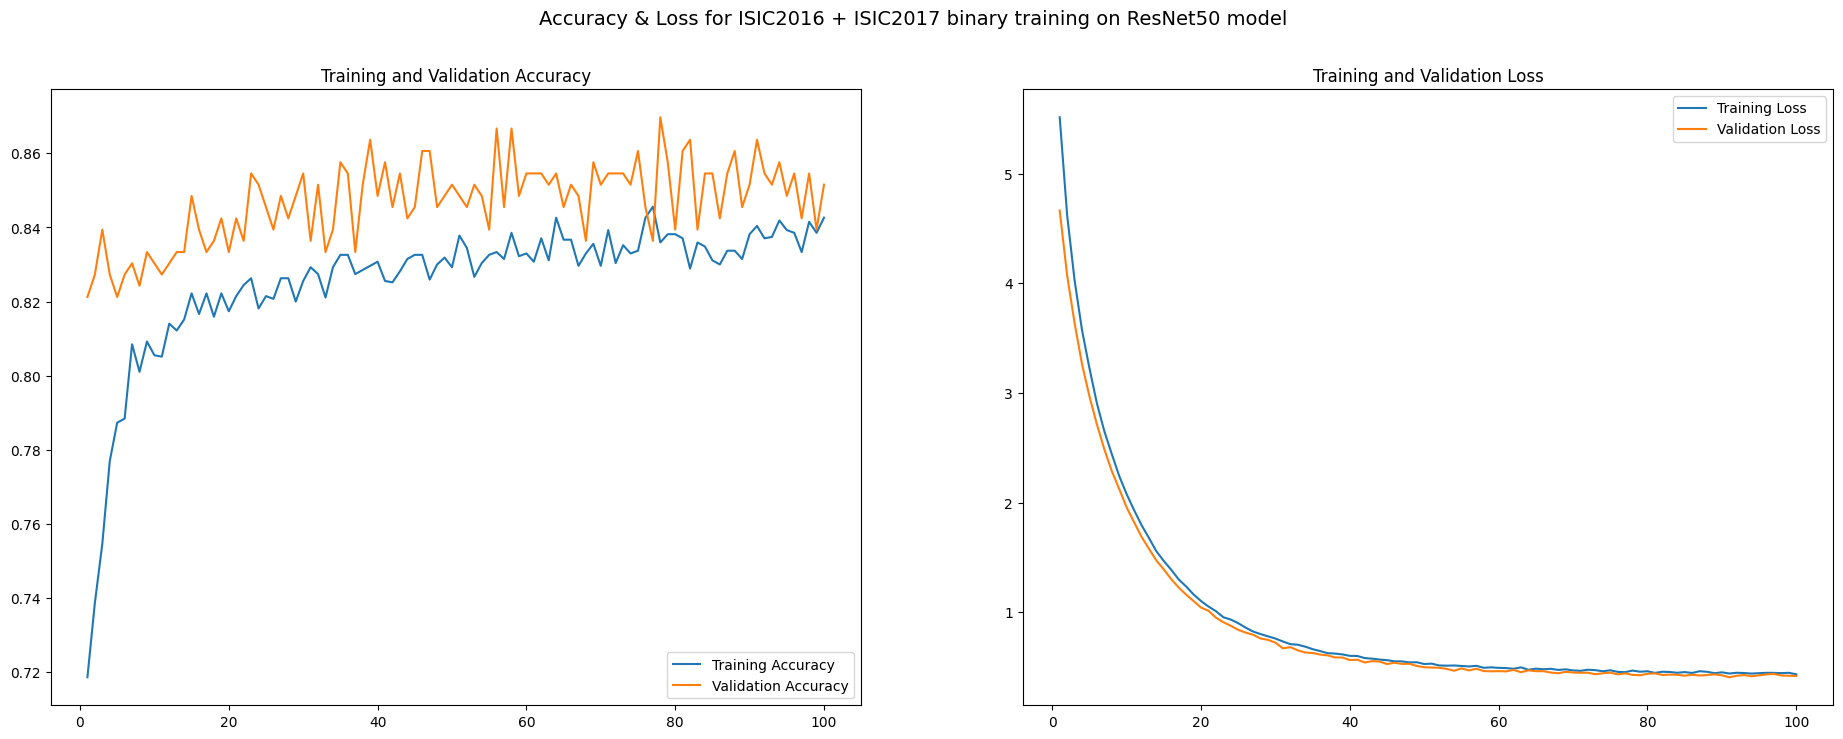

In [14]:
# ISIC2016 + ISIC2017 binary training

# Now, let's combine ISIC2016 AND ISIC2017 DBs
trainimages_combination = {"ISIC2016 train images":trainimages_ISIC2016, "ISIC2017 train images":trainimages_ISIC2017}
testimages_combination = {"ISIC2016 test images":testimages_ISIC2016, "ISIC2017 test images":testimages_ISIC2017}
validationimages_combination = {"ISIC2016 validation images":validationimages_ISIC2016, "ISIC2017 validation images":validationimages_ISIC2017}
trainlabels_combination = {"ISIC2016 train labels":trainlabels_binary_ISIC2016, "ISIC2017 train labels":trainlabels_binary_ISIC2017}
testlabels_combination = {"ISIC2016 test labels":testlabels_binary_ISIC2016, "ISIC2017 test labels":testlabels_binary_ISIC2017}
validationlabels_combination = {"ISIC2016 validation labels":validationlabels_binary_ISIC2016, "ISIC2017 validation labels":validationlabels_binary_ISIC2017}

trainimages_ISIC2016_ISIC2017 = utilInstance.combine_images(**trainimages_combination)
testimages_ISIC2016_ISIC2017 = utilInstance.combine_images(**testimages_combination)
validationimages_ISIC2016_ISIC2017 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_ISIC2016_ISIC2017 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_ISIC2016_ISIC2017 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_ISIC2016_ISIC2017 = utilInstance.combine_labels(**validationlabels_combination)


base_model_binary = mel.CNN(trainimages_ISIC2016_ISIC2017, trainlabels_binary_ISIC2016_ISIC2017, \
    validationimages_ISIC2016_ISIC2017, validationlabels_binary_ISIC2016_ISIC2017, \
        testimages_ISIC2016_ISIC2017, testlabels_binary_ISIC2016_ISIC2017, CFG)
ResNet50_name = 'ISIC2016 + ISIC2017 binary training on ResNet50'
data_gen_ISIC2016_ISIC2017, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train ISIC2016 + ISIC2017
history_ISIC2016_ISIC2017_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_ISIC2016_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2016_ISIC2017,
    validationimages = validationimages_ISIC2016_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2016_ISIC2017,
    data_gen = data_gen_ISIC2016_ISIC2017
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_ISIC2016_ISIC2017_bin
)

In [15]:
# Testing ISIC2016 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'ISIC2016 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC 2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating ISIC2016 binary ResNet50 model...

23/23 [==============================] - 1s 17ms/step - loss: 0.7353 - accuracy: 0.8512
Train loss = 0.7352609634399414  ;  Train accuracy = 85.12%

6/6 [==============================] - 0s 16ms/step - loss: 0.7314 - accuracy: 0.8833
Validation loss = 0.7314244508743286  ;  Validation accuracy = 88.33%

12/12 [==============================] - 0s 16ms/step - loss: 0.8000 - accuracy: 0.8175
Test loss = 0.7999572157859802  ;  Test accuracy = 81.75%
Evaluating ISIC2016 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.8293 - accuracy: 0.8350
Train loss = 0.8293459415435791  ;  Train accuracy = 83.50%

5/5 [==============================] - 0s 16ms/step - loss: 0.8709 - accuracy: 0.8200
Validation loss = 0.8709109425544739  ;  Validation accuracy = 82.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.9870 - accuracy: 0.8000
Test loss = 0.9870314598083496  ;  Test accuracy = 80.00%


In [16]:
# Testing ISIC2017 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'ISIC2017 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC 2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating ISIC2017 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.4431 - accuracy: 0.8345
Train loss = 0.44306620955467224  ;  Train accuracy = 83.45%

6/6 [==============================] - 0s 16ms/step - loss: 0.3835 - accuracy: 0.8722
Validation loss = 0.383525013923645  ;  Validation accuracy = 87.22%

12/12 [==============================] - 0s 16ms/step - loss: 0.4462 - accuracy: 0.8386
Test loss = 0.4461909830570221  ;  Test accuracy = 83.86%
Evaluating ISIC2017 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.4334 - accuracy: 0.8400
Train loss = 0.43337729573249817  ;  Train accuracy = 84.00%

5/5 [==============================] - 0s 16ms/step - loss: 0.4942 - accuracy: 0.8333
Validation loss = 0.4941977858543396  ;  Validation accuracy = 83.33%

19/19 [==============================] - 0s 16ms/step - loss: 0.5254 - accuracy: 0.8250
Test loss = 0.5253562331199646  ;  Test accuracy = 82.50%


In [17]:
# Testing ISIC2016 + ISIC2017 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'ISIC2016 + ISIC2017 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC 2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating ISIC2016 + ISIC2017 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.4091 - accuracy: 0.8442
Train loss = 0.4090694189071655  ;  Train accuracy = 84.42%

6/6 [==============================] - 0s 16ms/step - loss: 0.3567 - accuracy: 0.8833
Validation loss = 0.35669559240341187  ;  Validation accuracy = 88.33%

12/12 [==============================] - 0s 16ms/step - loss: 0.4339 - accuracy: 0.8413
Test loss = 0.43391790986061096  ;  Test accuracy = 84.13%
Evaluating ISIC2016 + ISIC2017 binary ResNet50 model...



63/63 [==============================] - 2s 16ms/step - loss: 0.4267 - accuracy: 0.8410
Train loss = 0.426738440990448  ;  Train accuracy = 84.10%

5/5 [==============================] - 0s 16ms/step - loss: 0.4902 - accuracy: 0.8267
Validation loss = 0.490217387676239  ;  Validation accuracy = 82.67%

19/19 [==============================] - 0s 16ms/step - loss: 0.5428 - accuracy: 0.8100
Test loss = 0.5427539944648743  ;  Test accuracy = 81.00%


In [18]:
# Testing HAM10000 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC 2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.5170 - accuracy: 0.8220
Train loss = 0.5170233249664307  ;  Train accuracy = 82.20%

6/6 [==============================] - 0s 16ms/step - loss: 0.4426 - accuracy: 0.8333
Validation loss = 0.4426238536834717  ;  Validation accuracy = 83.33%

12/12 [==============================] - 0s 16ms/step - loss: 0.4823 - accuracy: 0.8201
Test loss = 0.4823231101036072  ;  Test accuracy = 82.01%
Evaluating HAM10000 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.5158 - accuracy: 0.8220
Train loss = 0.5158482193946838  ;  Train accuracy = 82.20%

5/5 [==============================] - 0s 16ms/step - loss: 0.5673 - accuracy: 0.8067
Validation loss = 0.5672637224197388  ;  Validation accuracy = 80.67%

19/19 [==============================] - 0s 16ms/step - loss: 0.5735 - accuracy: 0.8033
Test loss = 0.5734913945198059  ;  Test accuracy = 80.33%


In [19]:
# Testing HAM10000 + ISIC2016 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 + ISIC2016 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

23/23 [==============================] - 1s 24ms/step - loss: 0.4794 - accuracy: 0.8206
Train loss = 0.47944995760917664  ;  Train accuracy = 82.06%

6/6 [==============================] - 0s 16ms/step - loss: 0.4116 - accuracy: 0.8500
Validation loss = 0.41163215041160583  ;  Validation accuracy = 85.00%

12/12 [==============================] - 0s 16ms/step - loss: 0.4653 - accuracy: 0.8201
Test loss = 0.46531856060028076  ;  Test accuracy = 82.01%
Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.4984 - accuracy: 0.8235
Train loss = 0.49837726354599  ;  Train accuracy = 82.35%

5/5 [==============================] - 0s 16ms/step - loss: 0.5448 - accuracy: 0.8067
Validation loss = 0.5448094010353088  ;  Validation accuracy = 80.67%

19/19 [==============================] - 0s 16ms/step - loss: 0.5790 - accuracy: 0.8050
Test loss = 0.5789622664451599  ;  Test

In [35]:
# Testing HAM10000 + ISIC2016 + ISIC2017 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 + ISIC2016 + ISIC2017 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 + ISIC2016 + ISIC2017 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.4700 - accuracy: 0.8164
Train loss = 0.4700008034706116  ;  Train accuracy = 81.64%

6/6 [==============================] - 0s 16ms/step - loss: 0.3974 - accuracy: 0.8556
Validation loss = 0.397428035736084  ;  Validation accuracy = 85.56%

12/12 [==============================] - 0s 16ms/step - loss: 0.4531 - accuracy: 0.8122
Test loss = 0.4530995786190033  ;  Test accuracy = 81.22%
Evaluating HAM10000 + ISIC2016 + ISIC2017 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.4734 - accuracy: 0.8210
Train loss = 0.4733904004096985  ;  Train accuracy = 82.10%

5/5 [==============================] - 0s 16ms/step - loss: 0.5159 - accuracy: 0.8000
Validation loss = 0.5158708095550537  ;  Validation accuracy = 80.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.5464 - accuracy: 0.8050
Test loss = 0.54644

In [58]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet50_out = ResNet50(
            include_top=False,
            # include_top=True,
            input_shape=(CFG['img_height'], CFG['img_width'], 3),
            # input_shape=(64, 64, 3),
            pooling = 'avg',
            weights='imagenet'
        )

model = mel.Model(trainimages_ISIC2017, trainlabels_binary_ISIC2017, \
    validationimages_ISIC2017, validationlabels_binary_ISIC2017, \
        testimages_ISIC2017, testlabels_binary_ISIC2017, CFG)

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

Resnet50_model = model.build_model(
    base_model = resnet50_out,
    base_model_name = 'Completely random model',
    model_optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
)



# Testing completely random model

test_loss, test_acc = Resnet50_model.evaluate(testimages_ISIC2016, testlabels_binary_ISIC2016, verbose = 1)
test_loss, test_acc = Resnet50_model.evaluate(testimages_ISIC2017, testlabels_binary_ISIC2017, verbose = 1)



# This is HAM10000 + ISIC2016 + ISIC2017

Resnet50_model.load_weights(modelpath)



test_loss, test_acc = Resnet50_model.evaluate(testimages_ISIC2016, testlabels_binary_ISIC2016, verbose = 1)
test_loss, test_acc = Resnet50_model.evaluate(testimages_ISIC2017, testlabels_binary_ISIC2017, verbose = 1)

Building Completely random model model...
19/19 [==============================] - 0s 16ms/step - loss: 0.5464 - accuracy: 0.8050
